Basic scikits-leaarn toolchain msetup

In [1]:
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier as Classifier
from sklearn.cross_validation import train_test_split

In [2]:
RANDOM_SEED = 33

In [21]:
signal = pd.DataFrame.from_csv('out_sig.txt', index_col= 0, sep=r'\t')
background = pd.DataFrame.from_csv('out_bk.txt', index_col= 0, sep=r'\t')
signal.columns = background.columns = [s.strip() for s in signal.columns]

emptycols = [c for c in signal.columns if c.startswith("Empty")]
signal.drop(emptycols, axis=1, inplace=True)
background.drop(emptycols, axis=1, inplace=True)

#signal = signal[signal[' Weight'] > 0.005]
#background = background[background[' Weight'] > 0.005]

data = pd.concat([signal, background])
features, weights = data.iloc[:, :-1], data.iloc[:,-1]
weights = np.abs(weights).as_matrix()
labels = np.r_[np.ones(len(signal)), np.zeros(len(background))]

#We split between testing and training by further starifying on weights, by ignoring the smaller ones for each
#category (for the purposes of splitting, we assign them to a third category '2' that tunrns out to be split evenly as well).
weighted_cats = labels.copy()
label_mask = labels.astype(bool)
small_signal = (weights < weights[label_mask].mean()) & label_mask
weighted_cats[small_signal] = 2

small_background = (weights < weights[~label_mask].mean()) & ~label_mask
weighted_cats[small_background] = 2


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, labels, weights,
                                                                     random_state = RANDOM_SEED, 
                                                                     test_size=0.5, stratify=weighted_cats)



#X_train, y_train, w_train = features, labels, weights

/home/zah/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:1177: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  infer_datetime_format=infer_datetime_format)


In [22]:
background.columns

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |',
       'Weight'],
      dtype='object')

In [23]:
signal.columns

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |',
       'Weight'],
      dtype='object')

In [24]:
len(X_train)

681

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   3.,    1.,    5.,   24.,   56.,   97.,  196.,  341.,  194.,  445.]),
 array([-17.10343741, -15.25380393, -13.40417046, -11.55453698,
         -9.70490351,  -7.85527003,  -6.00563655,  -4.15600308,
         -2.3063696 ,  -0.45673613,   1.39289735]),
 <a list of 10 Patch objects>)

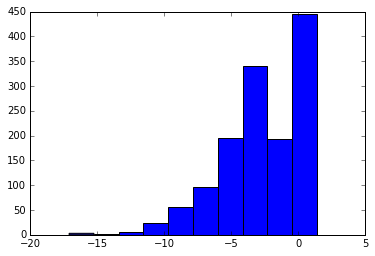

In [26]:
plt.hist(np.log10(weights))

In [27]:
len(data)

1362

In [28]:
sum(w_test)

623.20621939207774

In [29]:
sum(w_train)

555.39074949872554

In [30]:
sum(y_train*w_train)

435.32957446899422

In [31]:
sum(y_test*w_test)

467.94412222997329

In [32]:
clf = Classifier(n_estimators=10000, max_depth=4, min_weight_fraction_leaf=0.1, n_jobs=cpu_count() ,random_state=RANDOM_SEED)

In [33]:
clf.fit(X_train,y_train, sample_weight=w_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=10000, n_jobs=4,
            oob_score=False, random_state=33, verbose=0, warm_start=False)

In [34]:
clf.score(X_test, y_test, sample_weight=w_test)

0.75086561665966844

In [35]:
clf.score(X_train, y_train, sample_weight=w_train)

0.78382575666214493

In [36]:
est_scores = [est.score(X_test, y_test, sample_weight=w_test) for est in clf.estimators_]

In [37]:
from smpdflib.initialization import init_style
init_style()

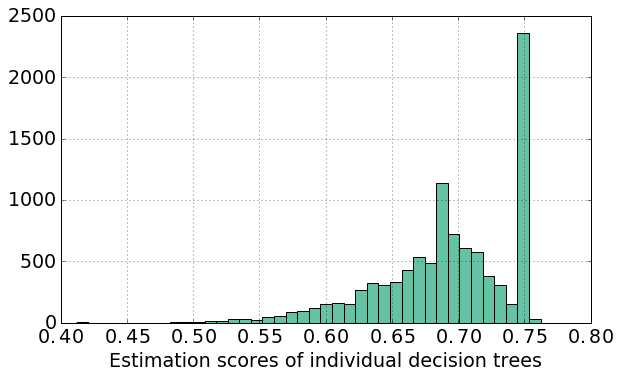

In [38]:
plt.hist(est_scores, bins=40)
plt.xlabel("Estimation scores of individual decision trees")
plt.savefig("ind_dt_dist.pdf")

In [39]:
sum(w_test)

623.20621939207774

In [40]:
sum(w_train)

555.39074949872554

In [41]:
importances = clf.feature_importances_

In [42]:
import matplotlib.pyplot as plt

In [43]:
importances = pd.Series(importances, index=features.columns)

In [44]:
sv = importances.sort_values()
c,d = sv.index[-2:]

In [45]:
best_features = sv.index[-4:]

In [46]:
sv

N of jets                        0.007196
mET phi                          0.038305
mET (scalar)                     0.039753
dijet min distance               0.040578
| Delta eta l1,l2 |              0.047529
j1 pT                            0.047577
j2 pT                            0.049305
m l1, l2                         0.049415
Delta R j1,j2                    0.056871
Cos |tot phi|                    0.058508
| Delta Phi l1, l2 |             0.059790
| Delta eta j1,j2 |              0.063398
Cos | deltaphi(j1+j2,l1+l2) |    0.068272
m j1, j2                         0.070962
W pT                             0.093228
Centrality                       0.094720
Zeppenfeld Var                   0.114592
dtype: float64

In [54]:
pairs = list(itertools.combinations(best_features,2))

In [56]:
best_features

Index(['m j1, j2', 'W pT', 'Centrality', 'Zeppenfeld Var'], dtype='object')

m j1, j2
m j1, j2
m j1, j2
W pT
W pT
Centrality


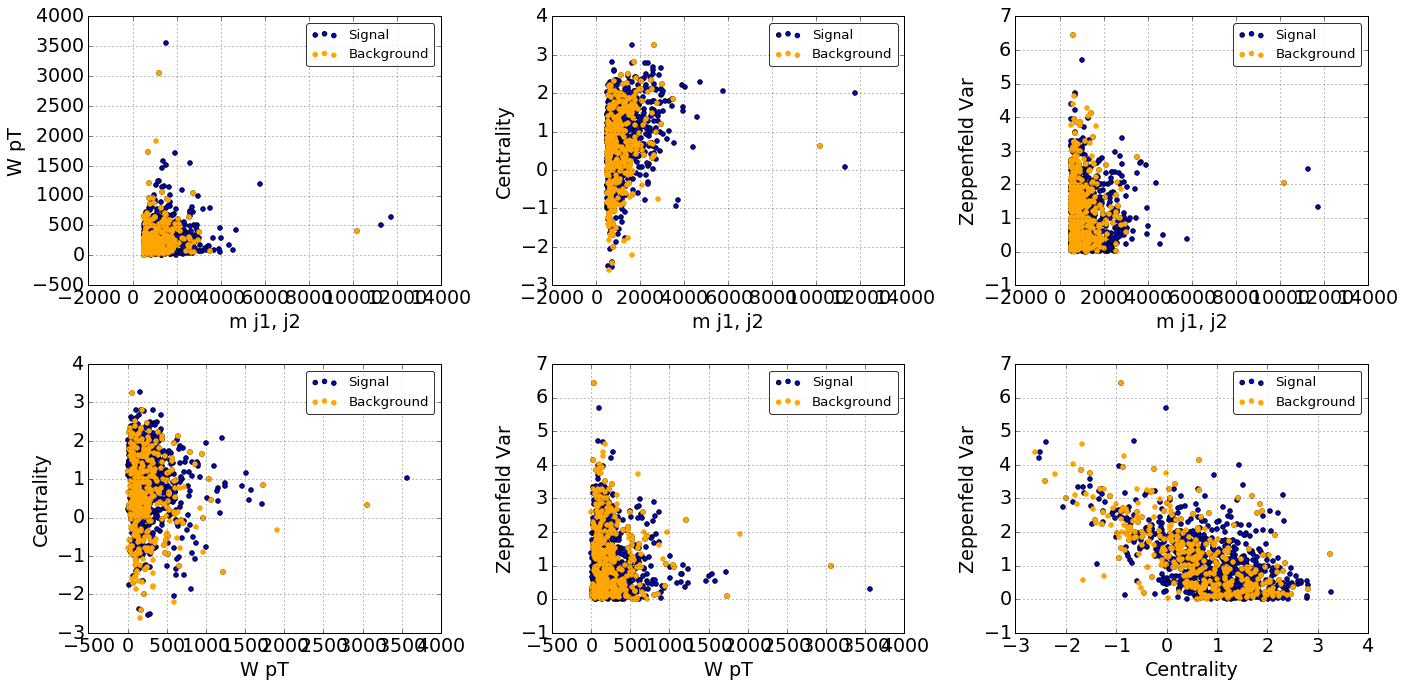

In [57]:
import itertools
pairs = (itertools.combinations(best_features,2))
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axiter = (ax  for l in axes for ax in l)
for (c,d), ax in zip(pairs, axiter):
    print(c)
    ax.scatter(c,d, data=signal, label="Signal")
    ax.scatter(c,d, data=background, color='orange', label="Background")
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.legend(loc='best')
plt.tight_layout()
plt.savefig("features.pdf")
    

In [58]:
proba_test = clf.predict_proba(X_test)

In [61]:
proba_test.shape

(681, 2)

In [62]:
len(X_test)

681

In [64]:
proba_test

array([[ 0.29930963,  0.70069037],
       [ 0.18123918,  0.81876082],
       [ 0.24009158,  0.75990842],
       ..., 
       [ 0.17052048,  0.82947952],
       [ 0.20918863,  0.79081137],
       [ 0.19941967,  0.80058033]])

In [ ]:
clf.